<a href="https://colab.research.google.com/github/prinzessinmarlenifee/SenseCap/blob/main/SenseCap_1trainingsession.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📋 Projekt-Ziel (bisher):

Wir haben ein Machine-Learning-Modell gebaut, das Mountainbike-IMU-Daten automatisch klassifiziert, z. B. in „Jumping“, „Pedaling“, „Resting“ usw.
Dafür haben wir:

    Label-Zeitstempel aus einer .json extrahiert

    Ein Label für jeden Frame erzeugt

    Die IMU-Daten in Fenster aufgeteilt

    Jedem Fenster ein Label zugewiesen

    Ein CNN+LSTM-Modell trainiert

    Die Test Accuracy und echte Vorhersagen ausgewertet

In [1]:
#mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json

# 1. JSON laden
with open('/content/drive/MyDrive/ML-MTB-Modell/Labeled/0713_0833_hot.json', 'r') as f:
    hot_data = json.load(f)

# 2. Labels parsen
button_press_str = hot_data['button_presses']
entries = button_press_str.strip().split(';')

label_changes = []
for entry in entries:
    if ':' in entry:
        label, frame = entry.strip().split(':')
        label_changes.append((int(frame.strip()), label.strip()))

# 3. Samplingrate anpassen
sampling_rate = 22  # ← wichtig: nicht 100 Hz!
total_seconds = 4200  # z. B. 70 min
total_frames = int(total_seconds * sampling_rate)

# 4. Frame-Array vorbereiten
frame_labels = ['Unknown'] * total_frames

for i, (start_frame, label) in enumerate(label_changes):
    end_frame = label_changes[i + 1][0] if i + 1 < len(label_changes) else total_frames
    for f in range(start_frame, min(end_frame, total_frames)):
        frame_labels[f] = label

# 5. Kontrolle
from collections import Counter
print("Beispiel-Labels:", frame_labels[10000:10020])
print("Label-Verteilung:", Counter(frame_labels))


Beispiel-Labels: ['Action', 'Action', 'Action', 'Action', 'Action', 'Action', 'Action', 'Action', 'Action', 'Action', 'Action', 'Action', 'Action', 'Action', 'Action', 'Action', 'Action', 'Action', 'Action', 'Action']
Label-Verteilung: Counter({'Action': 85738, 'Peadling': 3979, 'Resting': 2554, 'Unknown': 129})


🧠 Code-Erklärung

with open('0713_0833_hot.json', 'r') as f:
    hot_data = json.load(f)

🔹 Lädt die JSON-Datei mit den Zeitpunkten, an denen ein neuer Zustand beginnt (z. B. "Resting: 129").

button_press_str = hot_data['button_presses']
entries = button_press_str.strip().split(';')

🔹 Holt die "button_presses"-Zeile aus dem JSON
🔹 Teilt sie bei jedem ; in einzelne "Label: Frame"-Paare

label_changes = []
for entry in entries:
    if ':' in entry:
        label, frame = entry.strip().split(':')
        label_changes.append((int(frame.strip()), label.strip()))

🔹 Macht aus "Resting: 129" ein Tupel wie (129, "Resting")
🔹 Entfernt Leerzeichen, wandelt frame in int

sampling_rate = 22
total_seconds = 4200
total_frames = int(total_seconds * sampling_rate)
frame_labels = ['Unknown'] * total_frames

🔹 Rechnet aus, wie viele Frames du hast: 22 Hz × 4.200 Sek = 92.400 Frames
🔹 Erzeugt eine Liste mit "Unknown" als Platzhalter für jedes Frame

for i, (start_frame, label) in enumerate(label_changes):
    end_frame = label_changes[i + 1][0] if i + 1 < len(label_changes) else total_frames
    for f in range(start_frame, min(end_frame, total_frames)):
        frame_labels[f] = label

🔹 Für jedes Label-Zeitintervall schreibt es das passende Label in die frame_labels-Liste
🔹 So bekommt jeder Frame ein Label

from collections import Counter
print("Beispiel-Labels:", frame_labels[10000:10020])
print("Label-Verteilung:", Counter(frame_labels))

🔹 Zeigt dir ein paar Beispiel-Labels und wie oft jedes Label vorkommt


In [3]:
import numpy as np
from collections import Counter

# Parameter
window_size = 22  # 1 Sekunde bei 22 Hz
stride = 22       # ohne Overlap, sonst z. B. 11 für 50% Overlap

# Beispiel: Dummy-IMU-Daten (ersetzen durch echte!)
# imu_data = np.random.randn(len(frame_labels), 6)  # z. B. 6 Achsen: ax, ay, az, gx, gy, gz
# oder lade deine echten IMU-Daten hier rein

# Fenster + Label erstellen
windowed_data = []
windowed_labels = []

for start in range(0, len(frame_labels) - window_size + 1, stride):
    end = start + window_size
    window_labels = frame_labels[start:end]
    most_common_label = Counter(window_labels).most_common(1)[0][0]

    # imu_window = imu_data[start:end]  # wenn du echte Daten hast
    # windowed_data.append(imu_window)
    windowed_labels.append(most_common_label)

# Kontrolle
print("Anzahl Fenster:", len(windowed_labels))
print("Label-Verteilung (Fenster):", Counter(windowed_labels))


Anzahl Fenster: 4200
Label-Verteilung (Fenster): Counter({'Action': 3897, 'Peadling': 181, 'Resting': 116, 'Unknown': 6})


In [4]:
#Fensterbildung und Labelbildung

import numpy as np
from collections import Counter

# Parameter
window_size = 22  # 1 Sekunde bei 22 Hz
stride = 22       # ohne Overlap, sonst z. B. 11 für 50% Overlap

# Beispiel: Dummy-IMU-Daten (ersetzen durch echte!)
# imu_data = np.random.randn(len(frame_labels), 6)  # z. B. 6 Achsen: ax, ay, az, gx, gy, gz
# oder lade deine echten IMU-Daten hier rein

# Fenster + Label erstellen
windowed_data = []
windowed_labels = []

for start in range(0, len(frame_labels) - window_size + 1, stride):
    end = start + window_size
    window_labels = frame_labels[start:end]
    most_common_label = Counter(window_labels).most_common(1)[0][0]

    # imu_window = imu_data[start:end]  # wenn du echte Daten hast
    # windowed_data.append(imu_window)
    windowed_labels.append(most_common_label)

# Kontrolle
print("Anzahl Fenster:", len(windowed_labels))
print("Label-Verteilung (Fenster):", Counter(windowed_labels))


Anzahl Fenster: 4200
Label-Verteilung (Fenster): Counter({'Action': 3897, 'Peadling': 181, 'Resting': 116, 'Unknown': 6})


In [5]:
import numpy as np
from collections import Counter

# Beispiel: IMU-Daten-Array (dummy – hier musst du dein echtes IMU-Array nehmen!)
# Angenommen: imu_data.shape = (92839, 6) → [acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z]
imu_data = np.random.randn(92839, 6)  # ← Ersetze das durch deine echten Daten!

# Parameter
window_size = 22        # 1 Sekunde bei 22 Hz
step_size = 11          # 50 % Überlappung (optional)
num_samples = len(frame_labels)

X_windowed = []
y_windowed = []

for start in range(0, num_samples - window_size + 1, step_size):
    end = start + window_size

    window = imu_data[start:end]
    label_window = frame_labels[start:end]

    # Häufigstes Label im Fenster
    label_counts = Counter(label_window)
    dominant_label = label_counts.most_common(1)[0][0]

    # Optional: Unklare Fenster überspringen
    if dominant_label == 'Unknown':
        continue

    X_windowed.append(window)
    y_windowed.append(dominant_label)

X_windowed = np.array(X_windowed)
y_windowed = np.array(y_windowed)

print("Fenstergröße:", X_windowed.shape)
print("Beispielfenster Label:", y_windowed[:5])


Fenstergröße: (8388, 22, 6)
Beispielfenster Label: ['Resting' 'Resting' 'Resting' 'Resting' 'Resting']


In [6]:
#label encoder:

from sklearn.preprocessing import LabelEncoder

# Schritt 1: LabelEncoder vorbereiten
le = LabelEncoder()
y_encoded = le.fit_transform(y_windowed)

# Beispiel
print("Original Labels:", y_windowed[:5])
print("Integer Labels:", y_encoded[:5])
print("Klassen:", le.classes_)


Original Labels: ['Resting' 'Resting' 'Resting' 'Resting' 'Resting']
Integer Labels: [2 2 2 2 2]
Klassen: ['Action' 'Peadling' 'Resting']


In [7]:

#teilen in training und test daten


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_windowed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (6710, 22, 6) Test: (1678, 22, 6)


 Warum CNN + LSTM? ⚛

    CNN-Teil lernt lokale Muster (z. B. typische Bewegungen in kurzen Abschnitten)

    LSTM-Teil erkennt zeitliche Abläufe über das ganze Fenster hinweg

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = X_train.shape[1:]  # z. B. (22, 6)

model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.3),

    layers.Dense(100, activation='relu'),
    layers.Dense(len(np.unique(y_train)), activation='softmax')  # oder y_onehot.shape[1] wenn One-Hot
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # falls du y_encoded nutzt
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 18, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,395 (208.57 KB)

 Trainable params: 53,395 (208.57 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9100 - loss: 0.3838 - val_accuracy: 0.9291 - val_loss: 0.3048
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9314 - loss: 0.3002 - val_accuracy: 0.9291 - val_loss: 0.3041
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9291 - loss: 0.3059 - val_accuracy: 0.9291 - val_loss: 0.3053
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9258 - loss: 0.3158 - val_accuracy: 0.9291 - val_loss: 0.3091
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9301 - loss: 0.3003 - val_accuracy: 0.9291 - val_loss: 0.3078
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9286 - loss: 0.2980 - val_accuracy: 0.9291 - val_loss: 0.3290
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9336 - loss: 0.2774 - val_accuracy: 0.9291 - val_loss: 0.3121
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9258 - loss: 0.2917 - val_accu

In [10]:
#test accuracy auswerten

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9567 - loss: 0.1115 - val_accuracy: 0.9237 - val_loss: 0.4902
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9689 - loss: 0.0931 - val_accuracy: 0.9213 - val_loss: 0.4533
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9626 - loss: 0.1085 - val_accuracy: 0.9285 - val_loss: 0.5097
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9704 - loss: 0.0867 - val_accuracy: 0.9195 - val_loss: 0.4677
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9686 - loss: 0.0922 - val_accuracy: 0.9243 - val_loss: 0.5437
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9766 - loss: 0.0650 - val_accuracy: 0.9273 - val_loss: 0.5524
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9737 - loss: 0.0670 - val_accuracy: 0.9219 - val_loss: 0.5469
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9791 - loss: 0.0582 - val_accu

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


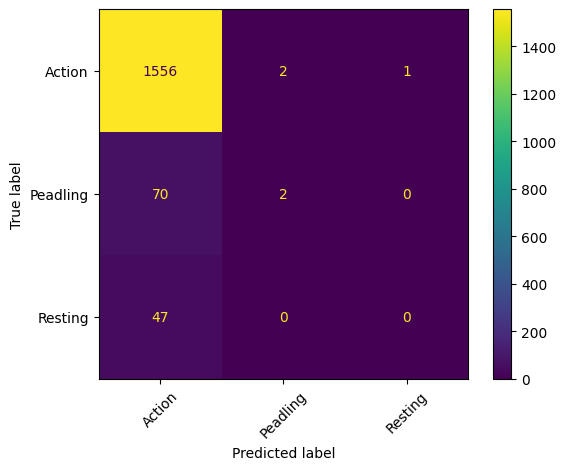

In [11]:
#confusion matrix
#welche klassen wurden gut und welche schlecht erkannt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)


✅  Precision, Recall & F1-Score aus der Confusion Matrix berechnet

Diese Metriken sagen  nicht nur wie viele richtig, sondern wie genau & vollständig das Modell bei jeder Klasse arbeitet.


🧠 Begriffe kurz erklärt:
Begriff	Bedeutung – pro Klasse
* Precision	Wie viele der „positiven Vorhersagen“ waren wirklich richtig?
* Recall	Wie viele der „echten Fälle“ hat das Modell richtig erkannt?
* F1-Score	Harmonie zwischen Precision & Recall – guter Gesamtwert

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_classes, target_names=le.classes_))


              precision    recall  f1-score   support

      Action       0.93      1.00      0.96      1559
    Peadling       0.50      0.03      0.05        72
     Resting       0.00      0.00      0.00        47

    accuracy                           0.93      1678
   macro avg       0.48      0.34      0.34      1678
weighted avg       0.89      0.93      0.90      1678



📌 Gut zu wissen:

    Hohe Precision, niedriger Recall: Modell ist vorsichtig – erkennt nicht alle Fälle, aber wenn, dann sicher

    Hoher Recall, niedrige Precision: Modell „schießt breit“ – erkennt viele Fälle, aber mit Fehlern

In [13]:
#extra F1-Score für gesamte Klassifikation

from sklearn.metrics import f1_score

f1_macro = f1_score(y_test, y_pred_classes, average='macro')  # alle Klassen gleich gewichtet
f1_weighted = f1_score(y_test, y_pred_classes, average='weighted')  # gewichtet nach Klassenhäufigkeit

print(f"Macro-F1: {f1_macro:.2f}")
print(f"Weighted-F1: {f1_weighted:.2f}")


Macro-F1: 0.34
Weighted-F1: 0.90


Endeee erstmal für erstes imu-Daten mit training daten

->Problem mit Resting

In [ ]:
for i, label in enumerate(pred_labels):
    if label == 'Jumping':
        print(f"Sprung erkannt bei Fenster {i} (Sekunde {i * step_size / 22:.1f})")


NameError: name 'pred_labels' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.plot([1 if l == 'Jumping' else 0 for l in pred_labels])
plt.title("Erkannte Sprünge über Zeit")
plt.xlabel("Fenster")
plt.ylabel("Jumping erkannt?")
plt.grid()
plt.show()


NameError: name 'pred_labels' is not defined